# Chapter 11 Analysis of Spike-Field Coherence during Navigation

## Step 1

### Load the data

In [2]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat


### Plot the first trail

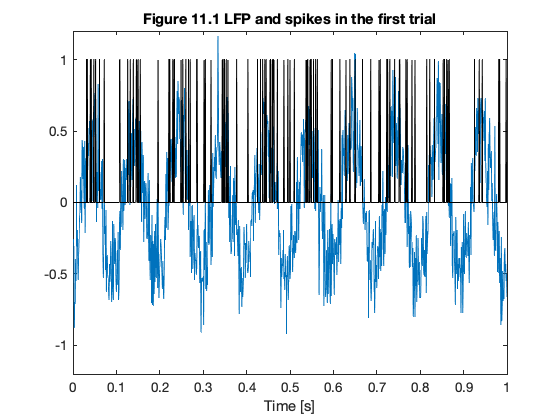

In [3]:
figure
plot(t, y(1, :))
hold on
plot(t, n(1, :), 'k')
hold off
ylim([-1, 1] * 1.2)
xlabel('Time [s]')
title('Figure 11.1 LFP and spikes in the first trial')


### Spike-triggered average (STA)

In [4]:
win = 100;
K = size(n, 1);
N = size(y, 2);
STA = zeros(K, 2 * win + 1);

for k = 1:K
    spks = find(n(k, :) == 1);

    for i = 1:length(spks)

        if spks(i) > win && spks(i) < N - win
            STA(k, :) = STA(k, :) + y(k, spks(i) - win:spks(i) + win) / length(spks);
        end % if

    end % for

end % for


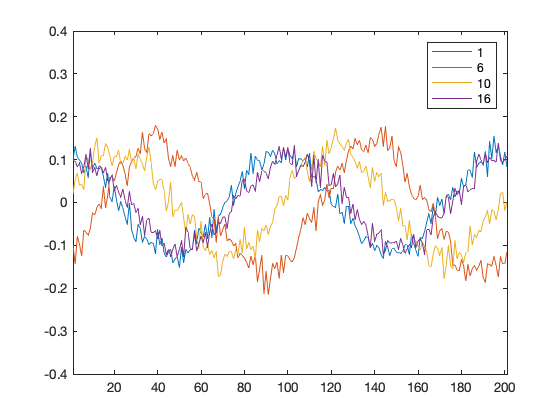

In [5]:
figure
plot(STA([1, 6, 10, 16], :)')
legend(["1", "6", "10", "16"])
xlim tight
ylim([-1, 1] * 0.4)
